In [149]:
import momepy
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights import Queen, Rook, KNN
import libpysal
%matplotlib inline

In [150]:
df = gpd.read_file('parcels_all.shp')

In [151]:
df = df.reset_index()[['index', 'Vacancy', 'geometry']]
df = df.rename(columns={'index': 'ID'})

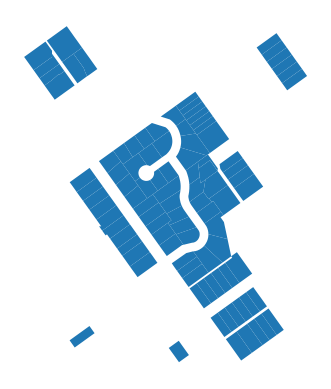

In [152]:
ax = df.plot()
ax.set_axis_off()

In [153]:
crs = df.estimate_utm_crs().to_epsg()
df = df.to_crs(crs)

# limit set at 1

In [154]:
buffer = 1

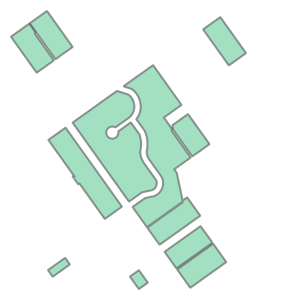

In [155]:
limit = momepy.buffered_limit(df, buffer=buffer)
limit

In [156]:
tessellation = momepy.Tessellation(df, unique_id='ID', limit=limit)

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


In [157]:
tessellation_gdf = tessellation.tessellation
tessellation_gdf = tessellation_gdf.reset_index(drop=True)

In [158]:
tessellation_gdf['ID'] = tessellation_gdf.index

In [159]:
tessellation_gdf.head()

,ID,geometry
0,0,"POLYGON ((481717.515 4399542.912, 481717.654 4..."
1,1,"POLYGON ((481722.950 4399535.513, 481722.855 4..."
2,2,"POLYGON ((481742.211 4399547.748, 481742.128 4..."
3,3,"POLYGON ((481754.331 4399557.064, 481754.048 4..."
4,4,"POLYGON ((481767.088 4399565.332, 481766.946 4..."


In [160]:
sw3 = momepy.sw_high(k=1, gdf=tessellation_gdf, ids='ID')

In [161]:
tessellation_gdf['n'] = momepy.Neighbors(tessellation_gdf, sw3,'ID').series

100%|██████████| 96/96 [00:00<?, ?it/s]


In [162]:
tessellation_gdf.head()

,ID,geometry,n
0,0,"POLYGON ((481717.515 4399542.912, 481717.654 4...",1
1,1,"POLYGON ((481722.950 4399535.513, 481722.855 4...",2
2,2,"POLYGON ((481742.211 4399547.748, 481742.128 4...",2
3,3,"POLYGON ((481754.331 4399557.064, 481754.048 4...",2
4,4,"POLYGON ((481767.088 4399565.332, 481766.946 4...",1


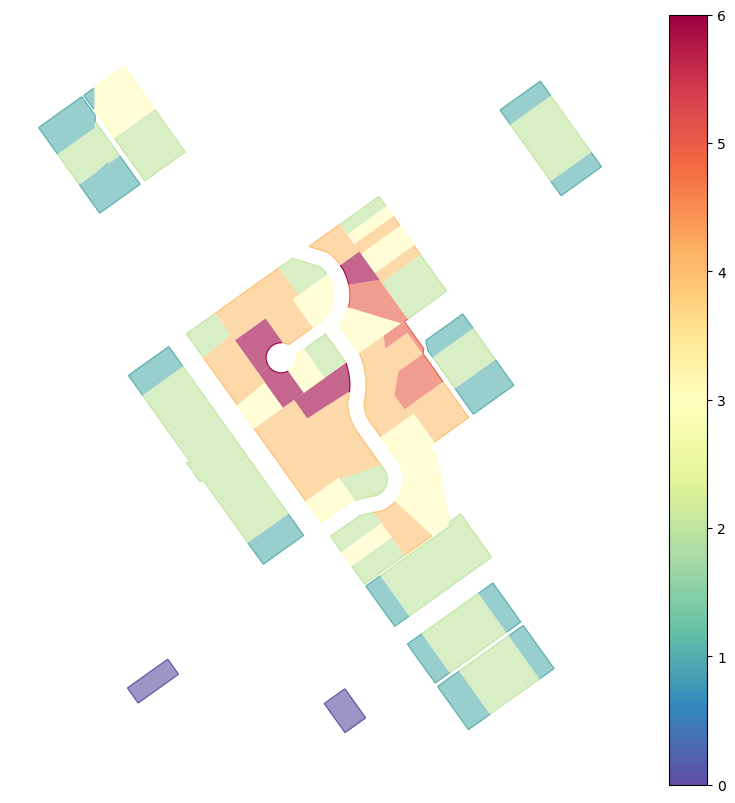

In [163]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation_gdf.plot(ax=ax, column='n', legend=True, cmap='Spectral_r')
df.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

In [164]:
df.to_file('parcels_all_ndist.shp')

In [12]:
rook = Rook.from_dataframe(tessellation_gdf)

d:\mini-forge\envs\growth_model\Lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 11 disconnected components.
 There are 2 islands with ids: 48, 58.
  warnings.warn(message)


In [13]:
all_ids = rook.id_order
islands = rook.islands


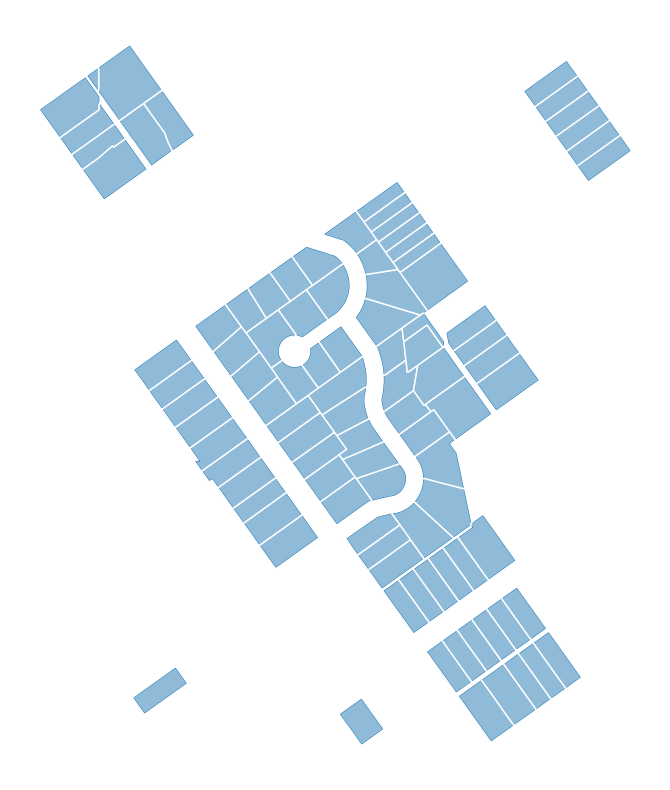

In [14]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation_gdf.plot(ax=ax, edgecolor='white')
df.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()

In [15]:
# remove islands from the list of all ids
all_ids = [x for x in all_ids if x not in islands]



In [16]:
for i in all_ids:
    print(f'ID: {i}: {rook.neighbors[i]}')

ID: 0: [1]
ID: 1: [0, 2]
ID: 2: [1, 3]
ID: 3: [2, 4]
ID: 4: [3]
ID: 5: [11, 6]
ID: 6: [5, 7]
ID: 7: [8, 6]
ID: 8: [7]
ID: 9: [30, 15]
ID: 10: [11]
ID: 11: [10, 5]
ID: 12: [13]
ID: 13: [12, 14]
ID: 14: [13, 15]
ID: 15: [9, 14]
ID: 16: [17, 50, 51, 49]
ID: 17: [16, 30, 31]
ID: 18: [52, 55]
ID: 19: [32, 20, 31]
ID: 20: [32, 19, 21, 22]
ID: 21: [24, 20, 22, 23]
ID: 22: [32, 20, 21, 24, 25]
ID: 23: [24, 25, 26, 21]
ID: 24: [25, 21, 22, 23]
ID: 25: [22, 23, 24, 26, 27]
ID: 26: [25, 27, 23]
ID: 27: [37, 88, 25, 26, 28]
ID: 28: [88, 29, 27, 37]
ID: 29: [88, 40, 28]
ID: 30: [9, 17]
ID: 31: [32, 17, 19]
ID: 32: [19, 20, 22, 31]
ID: 33: [34]
ID: 34: [33, 35]
ID: 35: [34, 36]
ID: 36: [35]
ID: 37: [27, 28]
ID: 38: [39]
ID: 39: [44, 38]
ID: 40: [88, 41, 29]
ID: 41: [40, 88, 42, 91]
ID: 42: [41, 91, 43]
ID: 43: [42, 91]
ID: 44: [45, 39]
ID: 45: [44, 46]
ID: 46: [45, 47]
ID: 47: [46]
ID: 49: [16, 50]
ID: 50: [16, 49, 51]
ID: 51: [16, 50]
ID: 52: [18, 53, 55]
ID: 53: [57, 52, 54, 55]
ID: 54: [56, 57, 5

In [17]:
# get component labels
components = rook.component_labels

combined_polygons = tessellation_gdf.dissolve(by=components)

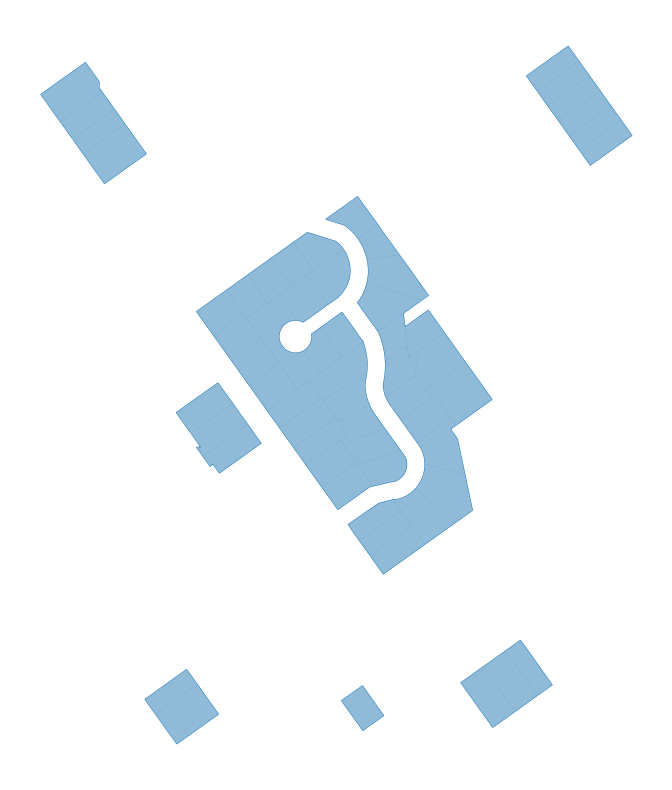

In [45]:
f, ax = plt.subplots(figsize=(10, 10))
combined_polygons.plot(ax=ax, edgecolor='white')
df.plot(ax=ax, color='white', alpha=.5)
ax.set_axis_off()
plt.show()

In [46]:
combined_polygons.to_file(f'combined_polygons_{buffer}_wdev2.shp')

In [25]:
combined_polygons_sindex = combined_polygons.sindex

In [26]:
def get_nearest(sindex, geometry):
    nearest = sindex.nearest(geometry.centroid, return_all=False, return_distance=True, max_distance=5)
    return nearest


In [27]:
def get_distance(df, offset):
    for poly in range(len(df)):
        ID = df.iloc[poly].ID
        # Calcualtes distance for each point from each df. If Point resides along edge of df( within 1-meter), distance is is given NUll then dropped
        df[f'd_to_{ID}'] = (df.apply(lambda x: 
                                                df.iloc[poly].geometry.distance(x['geometry']) 
                                                if df.iloc[poly].geometry.distance(x['geometry']) < offset 
                                                else 0, axis=1)
                                                )
    
    return df

In [49]:
combined_polygons_d = get_distance(combined_polygons, offset=20.0)

In [50]:
combined_polygons_d

,geometry,ID,d_to_0,d_to_1,d_to_4,d_to_10,d_to_12,d_to_20,d_to_43,d_to_54
0,"POLYGON ((481635.089 4399502.459, 481635.059 4...",0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
1,"POLYGON ((481669.145 4399644.884, 481634.474 4...",1,0.0,0.000000,12.955754,0.0,0.000000,0.0,0.0,0.0
2,"POLYGON ((481555.293 4399729.957, 481550.856 4...",4,0.0,12.955754,0.000000,0.0,18.080759,0.0,0.0,0.0
3,"POLYGON ((481479.409 4399529.315, 481479.412 4...",10,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
4,"POLYGON ((481527.294 4399737.959, 481531.733 4...",12,0.0,0.000000,18.080759,0.0,0.000000,0.0,0.0,0.0
5,"POLYGON ((481744.381 4399505.419, 481744.381 4...",20,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
6,"POLYGON ((481423.468 4399990.705, 481427.908 4...",43,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
7,"POLYGON ((481837.701 4399993.591, 481842.055 4...",54,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0


In [201]:
df = combined_polygons_d